In [2]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
from operator import itemgetter

2023-09-25 08:08:50.570498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create dataset

In [3]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)
question_embeddings_model = Doc2Vec.load("python.doc")
question_transformer_model = tf.keras.models.load_model(
    "../../scripts/text_model/question_transformer_model"
)
index = read_index("../../scripts/text_model/users_imp.index")

In [4]:
with open("../../scripts/text_model/user_embeddings.pickle", "rb") as f:
    user_embedding, user_encoder = pickle.load(f)

In [5]:
MIN_ANSWERS = 3
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date >= '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 30000"""
        )
        posts = cursor.fetchall()

In [6]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

In [7]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(3973, 50)

In [8]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

125/125 [==============================] - 0s 668us/step


(3973, 10)

In [9]:
qid2emb = {pid: emb for pid, emb in zip(posts_ids, questions_transformed)}

In [10]:
distances, similar_questions = index.search(questions_transformed, 10000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)

In [11]:
features_df

,q_id,u_id
0,70547027,15239951
0,70547027,15067558
0,70547027,9885747
0,70547027,9209546
0,70547027,12696163
...,...,...
3972,74681417,7145465
3972,74681417,8431101
3972,74681417,3218693
3972,74681417,4407260


In [12]:
batch_size = 1000000

results = []
with connection:
    for batch_idx in range(len(features_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                features_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
dataset = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [13]:
dataset.sort_values(by=["q_id"], inplace=True)
print(len(dataset))
dataset.head()

6411


,q_id,u_id,score
0,70547027,901925,4
80,70547027,2988730,0
20,70547027,2988730,2
42,70547281,786593,0
7,70547281,14531062,0


In [14]:
full_dataset = features_df.merge(dataset, on=["q_id", "u_id"], how="left")

In [15]:
full_dataset["feats"] = np.concatenate(
    (
        user_embedding[user_encoder.transform(full_dataset["u_id"])],
        np.array(itemgetter(*full_dataset["q_id"])(qid2emb)),
    ),
    axis=1,
).tolist()

In [16]:
scored_dataset = full_dataset[~full_dataset["score"].isna()]
eval_feats = np.array(scored_dataset["feats"].values.tolist())
eval_scores = scored_dataset["score"]
eval_q_ids = scored_dataset["q_id"]

# Load LTR

In [17]:
ranker = XGBRanker()
ranker.load_model("xgboost_ranker")

In [18]:
predicted_scores = ranker.predict(eval_feats)

grouped_predicted_scores = []
grouped_eval_scores = []

last_qid = eval_q_ids.values[0]
last_predicted_scores = []
last_eval_scores = []
for pscore, escore, q_id in zip(predicted_scores, eval_scores, eval_q_ids):
    if q_id == last_qid:
        last_predicted_scores.append(pscore)
        last_eval_scores.append(escore)
    else:
        grouped_predicted_scores.append(last_predicted_scores)
        grouped_eval_scores.append(last_eval_scores)
        last_predicted_scores = [pscore]
        last_eval_scores = [escore]
        last_qid = q_id

grouped_predicted_scores.append(last_predicted_scores)
grouped_eval_scores.append(last_eval_scores)

In [19]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

group_ncdg = []

for p_scores, e_scores in zip(grouped_predicted_scores, grouped_eval_scores):
    if len(p_scores) > 1:
        group_ncdg.append(ndcg_score([p_scores], [e_scores]))

group_ncdg = np.array(group_ncdg)
group_ncdg.mean(), group_ncdg.std()

(0.8636684026292202, 2.46910203239068)

# Evaluate recall

In [20]:
full_dataset["pscore"] = ranker.predict(np.array(full_dataset["feats"].values.tolist()))

In [35]:
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset["is_answer"].sum()

6411

In [22]:
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)

In [23]:
full_dataset.head(10)

,q_id,u_id,score,feats,pscore,is_answer
39721925,74681417,100297,NaN,"[0.3636975884437561, -0.17862990498542786, 0.3...",2.263848,0
39729612,74681417,142637,NaN,"[0.3586329221725464, -0.17869994044303894, 0.3...",2.089400,0
39720152,74681417,3874623,NaN,"[0.36579445004463196, -0.17795097827911377, 0....",2.024328,0
39720127,74681417,5923139,NaN,"[0.365764319896698, -0.17794328927993774, 0.36...",1.902712,0
39728376,74681417,7574575,NaN,"[0.3638848662376404, -0.17976972460746765, 0.3...",1.897878,0
39720281,74681417,2390182,NaN,"[0.3642725944519043, -0.17835688591003418, 0.3...",1.885602,0
39729133,74681417,325565,NaN,"[0.36622604727745056, -0.1847113072872162, 0.3...",1.845899,0
39720159,74681417,699305,NaN,"[0.36504852771759033, -0.17801634967327118, 0....",1.834514,0
39721374,74681417,95810,NaN,"[0.3644449710845947, -0.17890414595603943, 0.3...",1.815443,0
39728688,74681417,14101475,NaN,"[0.362300306558609, -0.17869533598423004, 0.36...",1.798422,0


In [24]:
total_questions = len(full_dataset["q_id"].unique())

In [25]:
top_k = [20, 100, 1000, 4000, 7000, 10000]
mean_retrieved_documents = []
for k in top_k:
    mean_retrieved_documents.append(
        full_dataset.groupby("q_id")
        .apply(lambda x: x.head(k)["is_answer"].sum())
        .median()
    )

In [26]:
mean_retrieved_documents

[0.0, 0.0, 0.0, 1.0, 1.0, 2.0]

In [27]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            where q_a.parent_id in %s
                            group by q_a.parent_id""",
            (tuple(posts_ids),),
        )
        q_answers = cursor.fetchall()

In [28]:
q_answers = {q_id: answers for q_id, answers in q_answers}

In [36]:
top_k = [20, 100, 1000, 4000, 7000, 10000]
mean_recall = []
for k in top_k:
    mean_recall.append(
        (
            full_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).mean()
    )

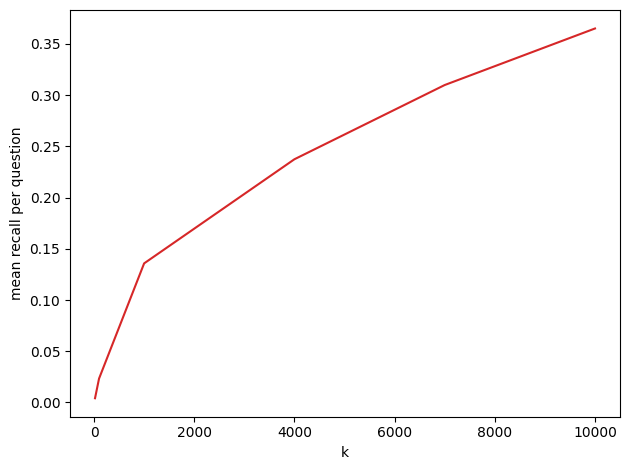

In [37]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color=color)

fig.tight_layout()
plt.show()

In [ ]:
get dev country with uid and idx

In [41]:
users = pd.read_csv("users_dev_country.csv")
users.head()

,user_id,country,value,developed_country
0,22545,new zealand,0.937,1
1,22550,india,0.633,0
2,22554,india,0.633,0
3,22562,germany,0.942,1
4,22564,ireland,0.945,1


In [42]:
full_dataset = full_dataset.join(
    users[["user_id", "developed_country"]].set_index("user_id"), on="u_id"
)
full_dataset.head()

,q_id,u_id,score,feats,pscore,is_answer,developed_country
39721925,74681417,100297,NaN,"[0.3636975884437561, -0.17862990498542786, 0.3...",2.263848,0,1.0
39729612,74681417,142637,NaN,"[0.3586329221725464, -0.17869994044303894, 0.3...",2.089400,0,NaN
39720152,74681417,3874623,NaN,"[0.36579445004463196, -0.17795097827911377, 0....",2.024328,0,1.0
39720127,74681417,5923139,NaN,"[0.365764319896698, -0.17794328927993774, 0.36...",1.902712,0,1.0
39728376,74681417,7574575,NaN,"[0.3638848662376404, -0.17976972460746765, 0.3...",1.897878,0,0.0


In [47]:
full_dataset["idx"] = full_dataset.groupby("q_id")["q_id"].cumcount()
full_dataset.head()

,q_id,u_id,score,feats,pscore,is_answer,developed_country,idx
39721925,74681417,100297,NaN,"[0.3636975884437561, -0.17862990498542786, 0.3...",2.263848,0,1.0,0
39729612,74681417,142637,NaN,"[0.3586329221725464, -0.17869994044303894, 0.3...",2.089400,0,NaN,1
39720152,74681417,3874623,NaN,"[0.36579445004463196, -0.17795097827911377, 0....",2.024328,0,1.0,2
39720127,74681417,5923139,NaN,"[0.365764319896698, -0.17794328927993774, 0.36...",1.902712,0,1.0,3
39728376,74681417,7574575,NaN,"[0.3638848662376404, -0.17976972460746765, 0.3...",1.897878,0,0.0,4


In [48]:
top_k = range(0, 100, 8)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

mean_recall = []
dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:
    mean_recall.append(
        full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
        )
        .mean()
    )
    dev_mean_recall.append(
        dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
        )
        .mean()
    )
    no_dev_mean_recall.append(
        no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: x[x["idx"] <= k]["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
        )
        .mean()
    )

In [49]:
len(full_dataset), len(dev_dataset), len(no_dev_dataset)

(39730071, 12312158, 13603954)

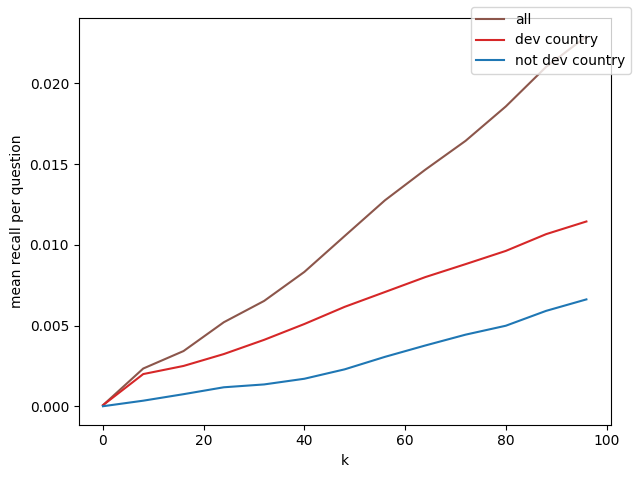

In [51]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall, color="tab:brown", label="all")
ax1.plot(top_k, dev_mean_recall, color=color, label="dev country")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="not dev country")

fig.tight_layout()
fig.legend()

In [38]:
top_k = [20, 100, 1000, 4000, 7000, 10000]
median_recall = []
for k in top_k:
    median_recall.append(
        (
            full_dataset.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).median()
    )

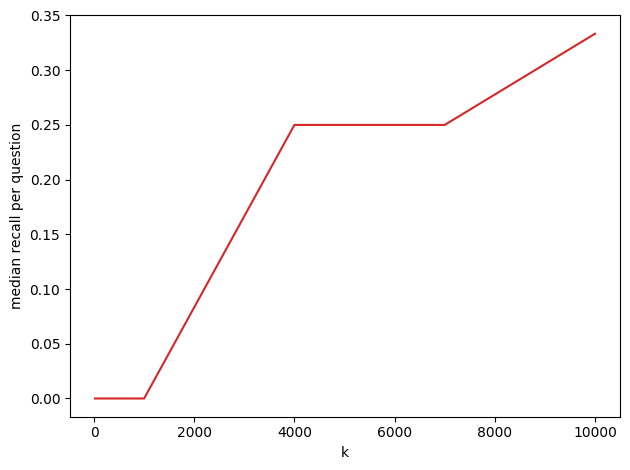

In [39]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("median recall per question")
ax1.plot(top_k, median_recall, color=color)

fig.tight_layout()
plt.show()

In [33]:
np.array(list(q_answers.values())).mean()

4.446010571356657

armar el end2end con los q nuevos, evaluar el recall, ncdg a p candidatos

In [ ]:

aramar el baseline con random

In [ ]:
median +iqr gapplot 

# Random candidates

In [9]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select u.id
        from users u""") --># respuesto preguntas de python
        users = cursor.fetchall()

# u.id, sum(respuest.score)
# from
# 	users
# 	respuestas por users
# 	preguntas de respuestas
# where
# 	preguntas de python
# group by u.id
# order by 2 desc
# limit N

In [10]:
len(users)

19307021

In [15]:
u_ids = np.random.choice(
    np.array(users).flatten(), size=len(posts_ids) * 10000, replace=True
)

In [24]:
random_df = pd.DataFrame(list(zip(posts_ids * 10000, u_ids)), columns=["q_id", "u_id"])
random_df.head()

,q_id,u_id
0,70547027,7762538
1,70547281,16095929
2,70547426,18799584
3,70549423,8793329
4,70550513,11930912


# Evaluate recall

In [31]:
results = []

with connection:
    for batch_idx in range(len(random_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                random_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
random_df_scores = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [32]:
random_df = random_df.merge(random_df_scores, on=["q_id", "u_id"], how="left")
random_df["is_answer"] = (~random_df["score"].isna()).astype(int)
random_df.head()

,q_id,u_id,score,is_answer
0,70547027,7762538,NaN,0
1,70547281,16095929,NaN,0
2,70547426,18799584,NaN,0
3,70549423,8793329,NaN,0
4,70550513,11930912,NaN,0


In [33]:
top_k = [20, 100, 1000, 4000, 7000, 10000]
mean_recall_random = []
for k in top_k:
    mean_recall_random.append(
        (
            random_df.groupby("q_id")[["is_answer", "q_id"]].apply(
                lambda x: x.head(k)["is_answer"].sum() / q_answers[x["q_id"].iloc[0]]
            )
        ).median()
    )

In [34]:
mean_recall_random

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

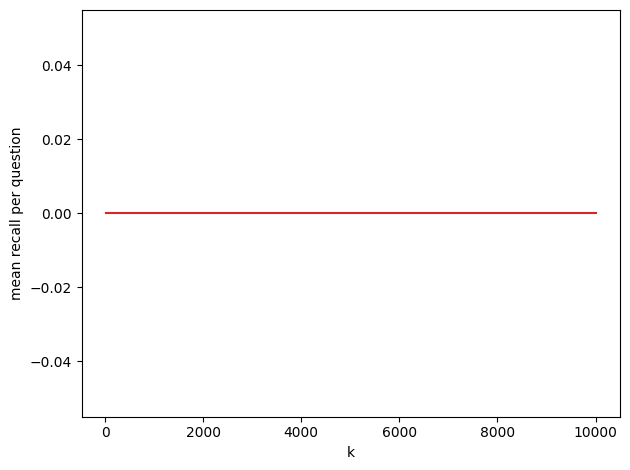

In [35]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall per question")
ax1.plot(top_k, mean_recall_random, color=color)

fig.tight_layout()
plt.show()